In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm
import copy
from hessian import *

import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# Dimer

In [3]:
dimer_wavenumbers = get_wavenumbers("dimer_normal_modes.molden")
dimer_frequencies = wavenumber_to_frequency(dimer_wavenumbers)

In [4]:
fig, ax = plt.subplots()

n_atoms = 280
n_modes = 3 * n_atoms - 6

Mg_index = 0

all_displacements = get_all_displacements("dimer_normal_modes.molden", n_atoms, n_modes)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


[-6.95074990e-03 -6.94790013e-03 -5.47093166e-03 -5.46720353e-03
 -4.12549687e-03 -4.12403787e-03 -4.00085210e-03 -3.99811190e-03
 -3.18136908e-03 -3.18055913e-03 -2.81848650e-04 -2.59005814e-04
 -7.89315168e-05  4.78354362e-04  4.83663117e-04  6.81845838e-04
  7.29802918e-04  7.58204626e-04  1.14254158e-03  1.15430913e-03
  1.20675596e-03  1.27526804e-03  1.31810449e-03  1.35865417e-03
  1.38494840e-03  1.39519546e-03  1.45000807e-03  1.46829253e-03
  1.49380823e-03  1.53052138e-03  1.83274980e-03  1.85279228e-03
  1.98989286e-03  2.00723270e-03  2.08441175e-03  2.08849298e-03
  2.15979897e-03  2.16906025e-03  2.20555447e-03  2.20731560e-03
  2.33191033e-03  2.35487225e-03  2.46131098e-03  2.46653324e-03
  2.68892472e-03  2.69516004e-03  2.75731286e-03  2.75827463e-03
  2.89704559e-03  2.90117901e-03  2.96741779e-03  2.96912520e-03
  3.10554902e-03  3.11603357e-03  3.38905340e-03  3.39073799e-03
  3.45063748e-03  3.45208305e-03  3.51066885e-03  3.51590017e-03
  3.67641421e-03  3.68059

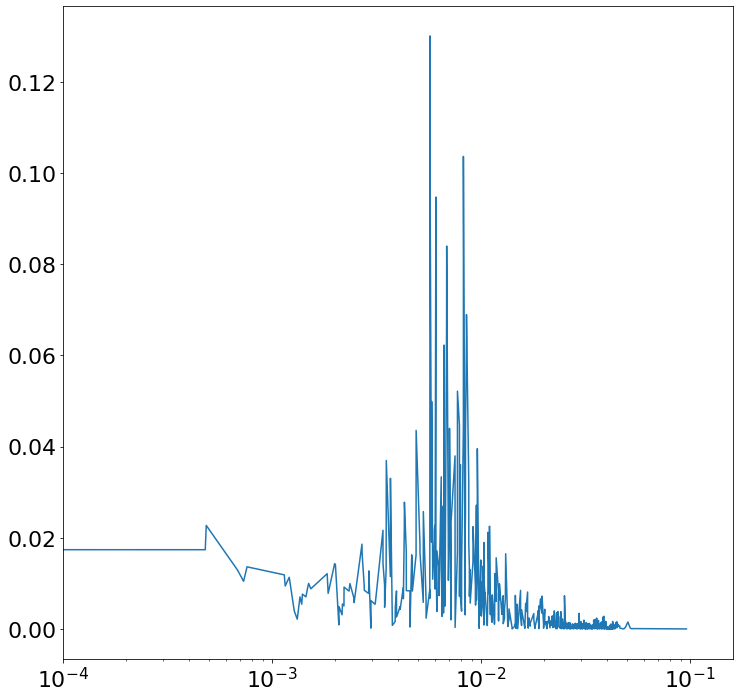

In [4]:
print(np.where(dimer_frequencies) > 0)

ax.plot(dimer_frequencies, all_displacements[Mg_index])

ax.set_xlim(1e-4, 0.16)

ax.set_xscale('log')

fig.set_size_inches(12,12)

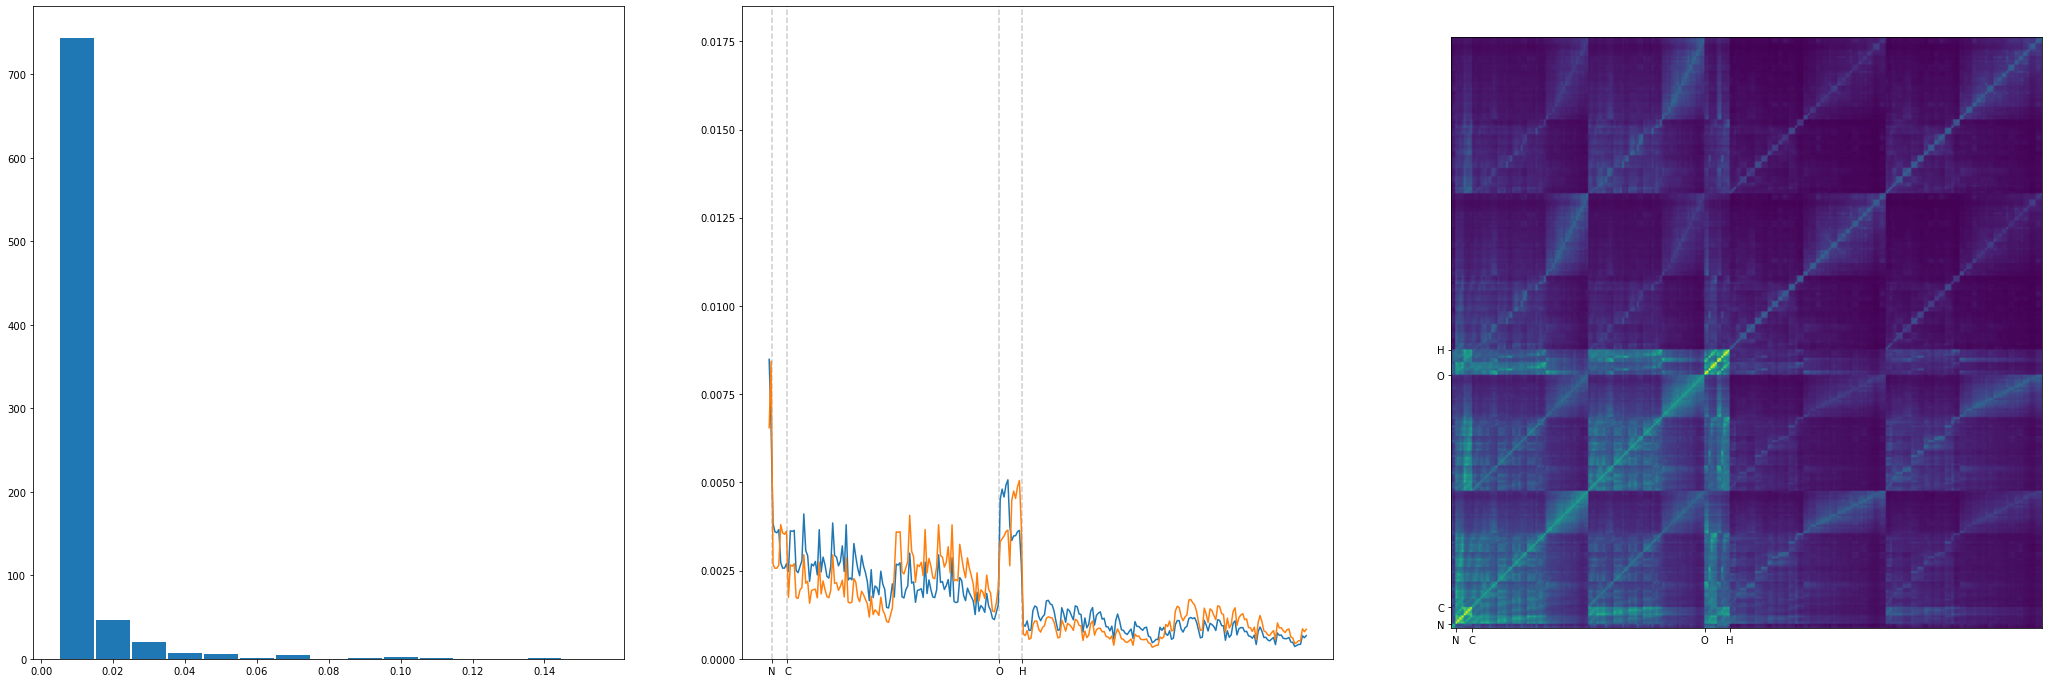

In [5]:
fig, ax = plt.subplots(1, 3)

symbols = read_symbols("dimer.xyz")

Mg_indices = np.array([enum for enum, x in enumerate(symbols) if x == "Mg"])
N_indices = np.array([enum for enum, x in enumerate(symbols) if x == "N"])
C_indices = np.array([enum for enum, x in enumerate(symbols) if x == "C"])
O_indices = np.array([enum for enum, x in enumerate(symbols) if x == "O"])
H_indices = np.array([enum for enum, x in enumerate(symbols) if x == "H"])

Mg_avg_disp= all_displacements[Mg_indices].max()
N_avg_disp = all_displacements[N_indices].max()
C_avg_disp = all_displacements[C_indices].max()
O_avg_disp = all_displacements[O_indices].max()
H_avg_disp = all_displacements[H_indices].max()

normalized_displacements = copy.copy(all_displacements)

normalized_displacements[Mg_indices] /= Mg_avg_disp
normalized_displacements[N_indices] /= N_avg_disp
normalized_displacements[C_indices] /= C_avg_disp
normalized_displacements[O_indices] /= O_avg_disp
normalized_displacements[H_indices] /= H_avg_disp

grouped_symbols = np.concatenate((Mg_indices, N_indices, C_indices, O_indices, H_indices))

normalized_displacements = normalized_displacements[grouped_symbols]

bins = np.linspace(0, 0.15, 16)
his = np.histogram(all_displacements[Mg_index], bins=bins)

ax[0].bar(his[1][1:], his[0], width=0.15/len(bins), align='center')
ax[0].set_xticks(bins[::2])

Mg_displacements = np.where(all_displacements[Mg_index] > 0.0)[0]

correlation = np.zeros((n_atoms, n_atoms))

for i in Mg_displacements:
    correlation += np.outer(normalized_displacements[:,i], normalized_displacements[:,i])
    
correlation /= len(Mg_displacements)

cax = ax[2].imshow(correlation, origin='lower', cmap=plt.get_cmap('viridis'))#, norm=LogNorm(vmin=0.0001, vmax=20))
    
#fig.colorbar(cax)

# number of each element --  Mg: 2, N: 8, C: 68, O: 8, H: 72
# cumulative -- 2, 10, 78, 86, 158

def ticks(symbols):
    Mg_indices= get_indices(symbols, "Mg")
    N_indices = get_indices(symbols, "N")
    C_indices = get_indices(symbols, "C")
    O_indices = get_indices(symbols, "O")
    H_indices = get_indices(symbols, "H")
    
    lengths = [len(Mg_indices), len(N_indices), len(C_indices), len(O_indices), len(H_indices)]
    
    cumulative = np.cumsum(lengths)
    
    ticks = np.array([x - 0.5 for x in cumulative[:-1]])
    
    return ticks

# number of each element --  Mg: 1, N: 4, C: 55, O: 6, H: 74
# cumulative -- 1, 5, 39, 43, 79

symbol_ticks = ticks(symbols)
symbol_labels= ["N","C","O","H"]

ax[2].set_xticks(symbol_ticks)
ax[2].set_xticklabels(symbol_labels)

ax[2].set_yticks(symbol_ticks)
ax[2].set_yticklabels(symbol_labels)

ax[1].plot(correlation[0])
ax[1].plot(correlation[1])
ax[1].set_xticks(symbol_ticks)
ax[1].set_xticklabels(symbol_labels)

ax[1].vlines(symbol_ticks, color='black', linestyle='--', ymin=0, ymax=max(correlation[0])+0.01, alpha=0.2)
ax[1].set_ylim(0, max(correlation[0])+0.01)

fig.set_size_inches(36,12)